In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
    
    

In [2]:
import sys
import math
import random
from numba import jit
from skimage.feature import peak_local_max
import itertools

import scipy.spatial

In [3]:
def reduce(g_1,k):
    h,w = g_1.shape
    new_h=int(h/2.)
    new_w=int(w/2.)
    g= np.zeros(shape=(new_h,new_w))
    for i in range(0,new_h):
        for j in range(0,new_w):
            for m in range(-2,2):
                for n in range(-2,2):
                    g[i,j]+=k[m,n]*g_1[2*i+m,2*j+n]
    return g

In [4]:
def pyramidG(orig,kernel,size):
    pyr=[]
    prev=orig
    for i in range(0,size):
        pyr.append(prev)
        prev=reduce(prev,kernel)
    return pyr

In [5]:
kernel=cv2.getGaussianKernel(5, 1.4) 
kernel=kernel.dot(kernel.T)

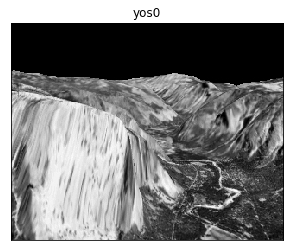

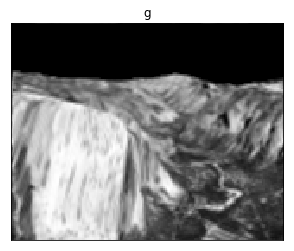

In [6]:
yos0 = cv2.imread('./images/DataSeq1/yos_img_01.jpg',0) 


#plt.figure(figsize=(20,30))
plt.imshow(yos0,cmap='gray')
plt.title('yos0'), plt.xticks([]), plt.yticks([])
plt.show()

g=reduce(yos0,kernel)

plt.imshow(g,cmap='gray')
plt.title('g'), plt.xticks([]), plt.yticks([])
plt.show()


In [7]:
pg=pyramidG(yos0,kernel,4)

h=252 w=316


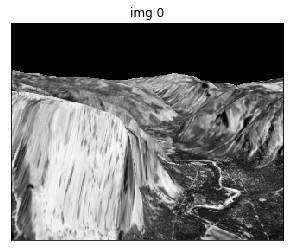

h=126 w=158


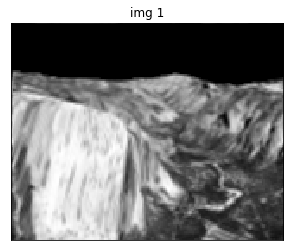

h=63 w=79


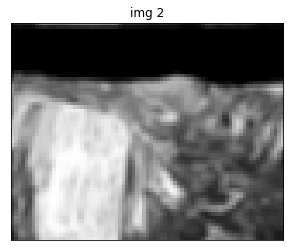

h=31 w=39


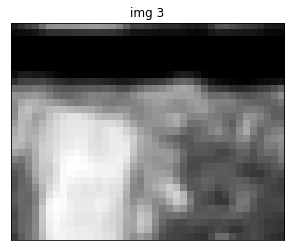

In [8]:
for i,img in enumerate(pg):
    h,w = img.shape
    print("h="+str(h)+" w="+str(w))
    plt.imshow(img,cmap='gray')
    plt.title('img '+str(i)), plt.xticks([]), plt.yticks([])
    plt.show()

In [21]:
def expand(g,k,prev_odd_w,prev_odd_h):
    h,w = g.shape
    print("h="+str(h)+" w="+str(w))
    new_h= (h)*2 
    new_h_resized=new_h
    if(prev_odd_h):
        new_h_resized+=1
    new_w= (w)*2
    
    new_w_resized=new_w
 
    if(prev_odd_w):
        new_w_resized+=1
    g_n= np.zeros(shape=(new_h_resized,new_w_resized))
    
    for i in range(2,new_h-2):
        for j in range(2,new_w-2):
            for m in range(-2,2):
                for n in range(-2,2):
                    new_i=(i-m)/2
                    new_j=(j-n)/2
                    if(new_i.is_integer() and new_j.is_integer()):
                        g_n[i,j]+=k[m,n]*g[int(new_i),int(new_j)]
    return 4*g_n

In [22]:
def pyramidL(orig,kernel,n):
    pg=pyramidG(yos0,kernel,n)
    pyr=[]
    prev=orig
    for j in range(0,n-1):
            prev_odd_h=False
            prev_odd_w=False
            gauss=pg[j]
            h,w = gauss.shape
            print("gauss h="+str(h)+" w="+str(w))
            if(h%2 ==1):
                prev_odd_h=True
            if(w%2 ==1):
                prev_odd_w=True
            
            gauss1=pg[j+1]
            exp=expand(gauss1,kernel, prev_odd_w, prev_odd_h)
            h,w = exp.shape
            print("exp h="+str(h)+" w="+str(w))
            
            gaussN=cv2.normalize(gauss,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            
            expN=cv2.normalize(exp,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            prev_lap= gaussN-expN            
            pyr.append(prev_lap)
    pyr.append(pg[n-1])    
    return pyr

In [23]:
p=pyramidL(yos0,kernel,4)

gauss h=252 w=316
h=126 w=158
exp h=252 w=316
gauss h=126 w=158
h=63 w=79
exp h=126 w=158
gauss h=63 w=79
h=31 w=39
exp h=63 w=79


h=252 w=316


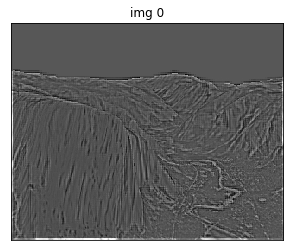

h=126 w=158


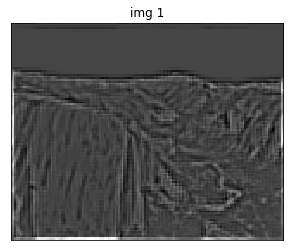

h=63 w=79


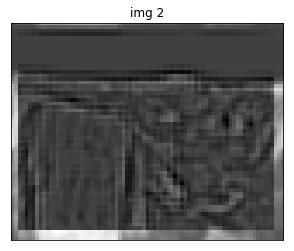

h=31 w=39


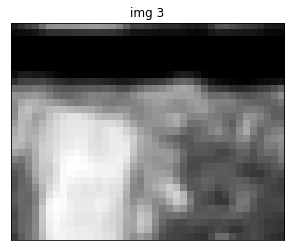

In [24]:
for i,img in enumerate(p):
        h,w = img.shape
        print("h="+str(h)+" w="+str(w))
        plt.imshow(img,cmap='gray')
        plt.title('img '+str(i)), plt.xticks([]), plt.yticks([])
        plt.show()

# 2

In [30]:
def gradPair(imgA):
    gxxA=cv2.Sobel(imgA,cv2.CV_64F,1,0);
    gyyA=cv2.Sobel(imgA,cv2.CV_64F,0,1);
    return gxxA,gyyA

In [ ]:
def LK(ImgA,ImgB,win,sigma=1.4,alpha=1):
    gxx,gyy=gradPair(ImgA)
    
    
        
    gxx2=gxx*gxx
    
    plt.imshow(gxx2,cmap='gray')
    plt.title('img '), plt.xticks([]), plt.yticks([])
    plt.show()
    
    Ixx=cv2.boxFilter(gxx2,-1,(win,win))
    
    plt.imshow(Ixx,cmap='gray')
    plt.title('img '), plt.xticks([]), plt.yticks([])
    plt.show()
        
    gyy2=gyy*gyy
    Iyy=cv2.boxFilter(gyy2,-1,(win,win))
    gxxyy=gxx*gyy
    Ixy=cv2.boxFilter(gxxyy,-1,(win,win))
    
    It=ImgA-ImgB
    
    
    plt.imshow(It,cmap='gray')
    plt.title('img '), plt.xticks([]), plt.yticks([])
    plt.show()  
    
    Itx=-cv2.boxFilter(It*gxx,-1,(win,win))
    Ity=-cv2.boxFilter(It*gyy,-1,(win,win))
    
    
    
    h,w=ImgA.shape
    R= np.zeros(shape=(h,w))
    
    halfWin=win//2
    bigI= np.zeros(shape=(h,w),dtype=np.ndarray)
    UV= []
    UV.append(np.zeros(shape=(h,w)))
    UV.append(np.zeros(shape=(h,w)))
    for i in range(0,h):
        for j in range(0,w):
            I=np.zeros(shape=(2,2))
            I[0,0]=Ixx[i,j]
            I[0,1]=Ixy[i,j]
            I[1,0]=Ixy[i,j]
            I[1,1]=Iyy[i,j]
            bigI[i,j]=I
            
    for i in range(halfWin,h-halfWin):
        for j in range(halfWin,w-halfWin):
            M=bigI[i,j]

            uv=np.linalg.pinv(M).dot([Itx[i,j],Ity[i,j]])
            
            UV[0][i,j]=uv[0]
            UV[1][i,j]=uv[1]
    return UV

In [ ]:
def printLK(UV):
    uMove=UV[0]+125
    print(UV[0])
    plt.imshow(uMove,cmap='gray')
    plt.title('img '), plt.xticks([]), plt.yticks([])
    plt.show()
    vMove=UV[1]+125
    
    plt.imshow(vMove,cmap='gray')
    plt.title('img '), plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
s0 = cv2.imread('./images/TestSeq/Shift0.png',0) 
s2 = cv2.imread('./images/TestSeq/ShiftR2.png',0) 

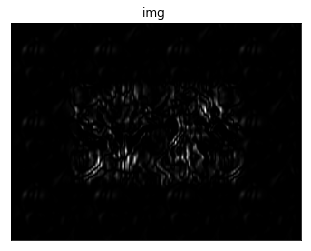

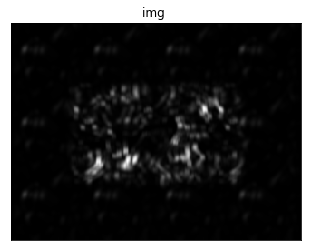

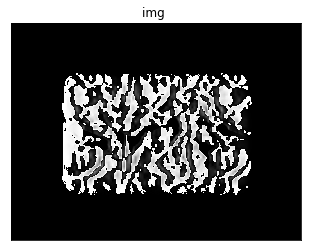

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[-1.31233651  0.35370359]
[-0.21538064  0.56440161]
[ 2.72487613  0.19712731]
[ 5.23466581 -1.66558768]
[ 5.72978165 -3.23486128]
[ 2.97506677 -1.13159035]
[ 0.47238151  1.83124151]
[ 2.52675245 -3.07330572]
[ 2.78752464 -5.90146731]
[ 2.3374122  -6.84263906]
[ 1.63022857 -6.36997351]
[ 1.0646961  -6.20504349]
[-0.03084407 -5.65238831]
[-0.89202835 -4.89426451]
[-0.91385842 -3.62667571]
[-0.18285586 -2.36369195]
[ 0.95419898 -1.48418402]
[ 2.17431093 -1.14678247]
[ 0.49638617 -0.70535685]
[-0.00225806 -0.00120271]
[-0.36025563  0.60070018]
[-0.18039974  0.32218772]
[-0.14437817  0.13385488]
[-0.07468293  0.68389245]
[-0.0138664   0.91078587]
[ 0.28757514  1.09996895]
[ 0.3969029   1.16815997]
[ 0.07754637  0.8940163 ]
[ 2.00899721  1.04692839]
[ 2.79060578  0.94135926]
[-0.65151619  0.07857459]
[-0.0159401   0.00679596]
[-0.02911844  0.00699059]
[-0.0279494   0.00846966]
[-0.02534691  0.00981659]
[-0.01108188  0.00898636]
[ 2.05503155 -0.28712192]
[ 2.37801204 -0.04843511]
[ 1.50637454

[ 7.88198226  1.97270432]
[ 8.81405332  0.9823766 ]
[ 8.68856698 -0.12720052]
[ 7.65516114 -0.90864666]
[ 5.71865869 -1.29837733]
[ 1.88313914 -0.27168143]
[-0.0707758  -0.05101737]
[ 3.00594789 -2.35788591]
[ 5.00631172 -2.78656977]
[ 7.29114328 -2.45824456]
[ 11.65983518   0.17533262]
[ 10.50166278  -0.60884584]
[ 11.12523134  -0.024913  ]
[ 3.72394871 -1.40602735]
[ 0.04749069 -0.04657258]
[ 3.28216744  0.68704152]
[ 4.77802847  2.93956317]
[ 5.91152851  9.79347388]
[  6.8180056   15.87639268]
[  9.53049755  18.25034051]
[  6.26645849  10.6495173 ]
[-1.7084197  -1.04672985]
[-1.96337605 -1.50750415]
[-0.62803673 -0.41683947]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.

[ 1.13830568  1.9194087 ]
[ 1.82069739  1.67759073]
[ 4.74724912  1.72469964]
[ 6.59188475  1.63791343]
[ 8.10663759  1.61439229]
[ 8.80264868  1.67641839]
[ 8.92432004  1.75849784]
[ 3.92994239  3.38250648]
[ 5.51456789  3.51066595]
[ 5.77514588  3.58055127]
[ 3.95571578  3.21676331]
[ 1.70931171  1.98221276]
[-0.2515803  -0.00518636]
[-0.24308081  0.03217911]
[-0.23288795  0.05411967]
[-0.24040757  0.07942296]
[-0.28174065  0.0911266 ]
[-0.2700969   0.07765244]
[ 1.86203948  0.30966642]
[ 4.85760062 -0.34967763]
[ 6.2530528  -0.35904041]
[ 6.49244423  0.27056935]
[ 6.71919765  1.26211502]
[ 6.87172912  0.93049251]
[ 6.06293032  3.56972017]
[ 2.56897924  5.68395214]
[ 0.71797549  4.9059467 ]
[-0.23912656  3.210944  ]
[-0.9175978   1.47383246]
[-1.00197867  0.16123882]
[-0.27087725  0.00076092]
[ 0.63893814  0.43215169]
[-1.01241191  2.15843837]
[-1.24272469  2.86158494]
[-0.95452239  3.5340899 ]
[-0.93104885  4.04221312]
[-1.53001678  2.94654354]
[-1.08466708  1.27493857]
[-0.41302045

[ 0.10002019  2.67696084]
[ 0.23278427  2.76830388]
[ 0.81849788  3.00009176]
[ 2.06700723  2.28575004]
[ 2.9779647   2.12487163]
[ 2.15785944  3.79203147]
[ 1.89053971  3.66794206]
[ 1.1667303   3.93964868]
[ 0.17449208  3.48358703]
[-0.31224081  1.85310066]
[ 0.26837003  0.4360117 ]
[ 0.69250613  0.68158932]
[ 1.00432675  0.90124831]
[ 1.54568612  1.11071776]
[ 1.36733332  1.62821998]
[ 1.84784997  1.83779755]
[ 2.0267239   2.02382202]
[ 1.78306344  2.24907781]
[ 1.71809867  2.1945854 ]
[ 1.96488771  1.42413849]
[ 2.32796835 -0.20588623]
[ 2.88348083 -1.47290112]
[ 1.55459517 -0.81953668]
[-0.84006613  0.62328808]
[-1.85728375  1.20293557]
[-0.07771535 -0.06077443]
[ 0.82897241 -0.55466566]
[ 1.4406511  -0.61718835]
[ 2.14347606 -0.19315743]
[ 1.06273898  1.39151551]
[ 0.926997    1.57378832]
[ 0.8682324   1.15525959]
[ 0.50836654  0.75068317]
[-0.01662756  0.30808105]
[-0.21498435  0.06431344]
[-0.23950371  0.00593916]
[ 0.16820125  0.05696544]
[ 1.05601092  0.18536003]
[ 2.18663705

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.29710218  1.44336972]
[-3.83912329  9.09493634]
[-2.76343228  9.93977245]
[ 0.04551534  9.13911096]
[ 1.96542737  9.94265558]
[ -1.74948084  11.31753219]
[ -1.44285267  10.10342057]
[-1.37457743  6.16193005]
[-0.90322033  2.48848498]
[-0.54215148  0.7034121 ]
[-0.25611969  0.0274711 ]
[ 0.34947958 -0.4285682 ]
[ 0.99765565 -0.56295802]
[ 1.811504   -0.80542648]
[ 2.18057877 -0.50209688]
[ 2.15100672  0.09553302]
[ 2.06347694  0.54803146]
[ 2.01777576  0.91296712]
[ 1.95644056  1.43105713]
[ 2.45118404  1.38008168]
[ 3.01187588  1.46930204]
[ 3.65570876  1.61576719]
[ 3.64122288  1.31201006]
[ 2.45936576  0.73610151]
[ 1.99573998  0.55664021]
[ 2.03663921  0.51852562]
[ 3.46976311  0.38619095]
[ 3.08455138  0.38469835]
[ 1.8566598   0.57946623]
[ 1.75619927  0.69032438]
[ 1.91049939  0.68071841]
[ 2.13796143  0.7881532 ]
[ 2.28152477  0.77831799]
[ 2.9541

[ 2.56988805 -2.69944366]
[ 2.67402919 -2.96722196]
[ 2.41834568 -3.70322842]
[ 2.30994212 -4.18992654]
[ 1.38206256 -5.4840311 ]
[-3.01260847 -8.52674006]
[-8.285505   -9.41888536]
[ 2.66138648 -2.1787601 ]
[ 5.76753852  0.21323496]
[ 5.67858258  0.47225824]
[ 5.01862563  0.30924983]
[ 4.63698921 -0.04625905]
[ 4.26873787 -0.42957459]
[ 3.86909762 -1.48765883]
[ 3.15658107 -2.08151444]
[ 2.74068975 -2.38152449]
[ 2.32846206 -2.28351   ]
[ 1.89037066 -2.34427622]
[ 1.99530063 -2.16591053]
[ 2.2146418  -1.78838053]
[ 2.29805467 -1.20637331]
[ 1.95897692 -1.09879835]
[ 1.39809158 -1.228632  ]
[ 0.42531519 -0.65389975]
[-0.11375138 -0.07297374]
[-0.32064569  0.28373694]
[-0.12801122 -0.27931716]
[-0.11698856 -0.33980808]
[ 0.06793295 -0.78227024]
[ 0.30238682 -1.1676424 ]
[ 1.0360719  -1.10565187]
[ 2.53772489  0.01497547]
[ 2.86608687 -0.89602606]
[ 2.77560235 -1.17979693]
[ 2.50999452 -1.17788087]
[ 2.21288494 -1.08362901]
[ 2.10937001 -1.25976131]
[ 1.91681706 -1.24794924]
[ 1.8022351 

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 2.72503288 -3.18743305]
[ 4.48966879 -5.04218453]
[ 4.66602728 -5.41544917]
[ 2.55790042 -4.8320687 ]
[ 1.37641707 -5.02452407]
[ 1.17418234 -5.43979046]
[ 1.58330713 -6.00191842]
[-0.33109778 -6.84274736]
[-0.04090487 -7.86583433]
[-0.12908158 -7.28543757]
[-0.4856498  -4.49557577]
[-0.51910478 -1.47618116]
[ 0.21812472  0.9557843 ]
[ 1.27769045  2.09800168]
[ 1.65219618  1.82782078]


[ 0.99667442 -1.941118  ]
[-0.20922805 -0.11867385]
[ 0.38999708 -0.78948337]
[ 1.26369979 -1.17280724]
[ 1.97449452 -0.72643257]
[ 1.99754219 -0.41897109]
[ 1.78313464 -0.53405289]
[ 1.75334254 -0.49983846]
[ 1.64520635 -0.64383342]
[ 1.34059984 -1.24799812]
[ 1.19228514 -1.69338851]
[ 1.94868327 -1.11814288]
[ 3.14259374 -0.36264757]
[ 4.10280455  0.02328936]
[ 5.51399943  0.45053599]
[ 6.10300842  0.19212627]
[ 6.19892237 -0.40943106]
[ 4.45340784 -1.67210175]
[ 4.65711641 -1.85354498]
[ 3.08362793 -1.69611182]
[ 0.9008826  -0.93179964]
[ 0.06552861 -0.33133042]
[-0.16723485  0.00098289]
[-0.18044416  0.00090577]
[-0.19953312 -0.01579873]
[-0.18626083 -0.05685713]
[-0.18395905 -0.06571577]
[-0.17847023 -0.07783862]
[ 0.25652716 -0.40076774]
[ 0.44884271 -0.47693768]
[-0.21241683  0.09789562]
[-0.16589603  0.10342488]
[-0.1347096   0.13083198]
[-0.20743202  0.14537439]
[-0.28823938 -0.07905785]
[-0.34283149 -0.47223449]
[-0.49271525 -0.74186124]
[-0.43506209 -0.94886187]
[-0.22942489

[  2.98446569e-04   4.46142191e-01]
[-0.26249287 -0.01426588]
[-0.22687268  0.03501224]
[-0.26569245 -0.08387739]
[-0.33011685 -0.36533388]
[-0.22648776 -0.59529213]
[ 0.65311601 -0.41393168]
[ 1.29121187 -0.40333502]
[ 1.26639633 -0.7525342 ]
[ 1.32845714 -0.71240837]
[ 1.42668697 -0.69153759]
[ 1.56181744 -0.68486775]
[ 1.67550738 -0.74120896]
[ 1.89169208 -0.80033571]
[ 2.57292374 -0.64532834]
[ 2.91878454 -0.61850048]
[ 3.29780944 -0.60879086]
[ 3.50708624 -0.58615951]
[ 3.5571109  -0.52604108]
[ 3.1321229  -0.57663676]
[ 1.82990685 -0.50555805]
[ 0.44383063 -0.2354997 ]
[-0.13124905 -0.04162092]
[-0.20516573 -0.00183624]
[-0.20537931 -0.01207882]
[-0.20804024 -0.0248386 ]
[-0.0845208  -0.12051456]
[ 0.14813166 -0.30012373]
[ 0.58491724 -0.61249176]
[ 1.29792275 -1.04184002]
[ 2.69664846 -1.49090677]
[ 3.38489135 -0.35359327]
[ 3.76607163  0.95637674]
[ 3.94582961  2.49773329]
[ 4.8454247   1.26739899]
[ 7.56447131 -2.68331944]
[ 10.34723312  -6.99898112]
[ 8.89644248 -4.03627809]


[-0.12592941  0.1159942 ]
[ 0.33554309  0.36936764]
[ 0.52841844  0.34518366]
[ 0.61716178  0.36475081]
[ 0.33483739  0.55022292]
[ 0.26029459  0.66445145]
[ 0.6723863   0.49897715]
[ 1.20705793  0.47677016]
[ 1.06305396  0.4312184 ]
[ 1.02958155  0.36694204]
[ 1.2981516   0.31492283]
[ 1.5039019   0.38500839]
[ 1.4412198   0.59049906]
[ 0.63595492  1.12298275]
[ 1.49730413  1.12084989]
[ 3.16062015  1.10642133]
[ 3.15232932  1.08561636]
[ 1.79447871  0.76482357]
[ 0.07159065  0.12703216]
[ 0.14133185  0.15917525]
[ 0.0890866   0.15725131]
[ 0.68815763  0.42176643]
[ 0.81843216  0.49682767]
[ 0.80866681  0.51997886]
[ 0.60795669  0.21640414]
[ 0.65904653 -0.0672112 ]
[ 1.15148632 -0.37281829]
[ 1.47063124 -0.50807284]
[ 1.60461902 -0.52967441]
[ 1.64214505 -0.52996873]
[ 1.73512288 -0.63769296]
[ 1.80163889 -0.50837   ]
[ 1.89279988 -0.26591317]
[ 2.01665762  0.08823917]
[ 2.6619792   0.38974596]
[ 1.209689    1.12409158]
[ 0.1987471   0.99539287]
[-0.15446912  0.73074745]
[-0.27534794

[-0.20552813  0.70573389]
[-0.38161225  0.2285293 ]
[-0.24164011 -0.41015058]
[ 0.4274858  -0.48376983]
[ 1.17244961 -0.44114354]
[ 1.63741569 -0.33112377]
[ 1.93183061 -0.26202679]
[ 2.25753224  0.57965241]
[ 2.72468578 -0.43095823]
[ 3.93199051 -1.6550164 ]
[ 4.29355282 -1.8186121 ]
[ 3.80996002 -1.79761735]
[ 2.47174653 -1.4688159 ]
[ 0.52136101 -1.13877645]
[-0.41716928 -0.74810761]
[ 0.15737708 -0.22051287]
[ 0.77304233  0.59760331]
[ 0.84057281  1.17271724]
[ 1.04901631  1.23980929]
[ 1.12544363  1.12804483]
[ 1.11277679  1.09440698]
[ 0.95600184  1.02669021]
[ 0.02052201  0.25326376]
[-0.12843222  0.09120601]
[-0.17146312  0.06601127]
[-0.18762921  0.06490687]
[-0.09408598  0.14371963]
[ 0.19278523  0.3021688 ]
[ 0.65056816  0.34411418]
[ 0.95416337  0.37199141]
[ 0.27012297  0.59376679]
[ 0.3122462   0.70753731]
[ 0.36646715  0.74003255]
[ 0.59281871  0.8853054 ]
[ 0.86257942  1.11429843]
[ 0.80001616  1.01392479]
[ 0.6441634   0.71278159]
[ 0.4598247   0.11764346]
[-0.09901772

[ 0.  0.]
[ 5.56403908 -1.03065859]
[ 10.24893293  -2.85795982]
[ 10.19192774  -3.43042778]
[ 8.66084262 -2.79229163]
[ 6.19772475  0.35357533]
[ 3.7711742   4.56637514]
[ 3.37482783  5.5141514 ]
[ 3.73787272  4.37626224]
[ 3.19306105  5.87686999]
[ 2.76523683  7.29515491]
[ 2.67656548  3.14031703]
[ 2.49951296 -0.66454913]
[ 2.38545756 -1.74022143]
[ 2.0657996 -1.5168058]
[ 0.81464221 -0.80618399]
[ 0.11360086 -0.32528433]
[-0.1566107  -0.14119746]
[-0.27572254 -0.02981026]
[-0.18017767 -0.02133201]
[-0.12212109 -0.00688049]
[ 0.34997964  0.16317074]
[ 1.25689998  0.30603489]
[ 2.17513807  0.11797937]
[ 2.65144342 -0.09731757]
[ 2.47040339 -0.16738907]
[ 2.75723303 -0.33501648]
[ 1.14639928  0.19663429]
[ 0.50292903  0.38975642]
[ 0.36437487  0.37258171]
[ 0.33522756  0.29695092]
[ 0.7964593   0.35818571]
[ 1.80115386  0.36956247]
[ 3.13334524  0.22540293]
[ 3.46977372  0.0235177 ]
[ 3.37907536  0.19006331]
[ 2.94455159  0.20848494]
[ 2.58849123  0.35429767]
[ 2.49475416  0.46101924]


[ 0.14223842 -0.21619833]
[ 0.39182222 -0.35852176]
[ 0.69775495 -0.48843513]
[ 1.08936667 -0.60915609]
[ 1.46300878 -0.50237821]
[ 1.81885699 -0.00822969]
[ 2.09081084  0.33335394]
[ 2.54186441  0.44758559]
[ 2.26068986  0.7327493 ]
[ 1.69366749  0.92085309]
[ 1.53557769  0.57885226]
[ 1.44525395 -0.23517341]
[ 1.23185431 -0.82723001]
[ 1.08161097 -0.94614823]
[ 0.99114086 -0.83091023]
[ 0.38157323 -0.68120954]
[-0.84629823 -0.57412843]
[-0.52467429 -0.36444194]
[-0.34267561 -0.13346358]
[-0.17222762  0.0573517 ]
[-0.20323276  0.08760421]
[-0.17609555  0.05569746]
[ 0.03316427 -0.19321744]
[ 0.54198513 -0.87706343]
[ 0.55007081 -1.10091038]
[ 1.36305341 -1.21693427]
[ 2.01543413 -1.18320795]
[ 2.48554526 -1.0509318 ]
[ 2.7249985  -0.77248493]
[ 3.3146341  -0.68202817]
[ 4.1554939  -0.65135723]
[ 4.62045028 -0.58084094]
[ 3.02812521 -0.07172545]
[ 1.48426305  0.47678203]
[ 0.55792459  0.6660789 ]
[-0.55718146  0.75166434]
[ 0.30397206  0.78131529]
[ 1.05978295  0.70831323]
[ 0.1636632 

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 3.56158539 -0.04123174]
[ 3.71047269  0.03270946]
[ 4.70721678 -0.37310719]
[ 12.03040025  -2.11178241]
[ 13.1317827   -2.30625042]
[ 13.00424839  -1.9126479 ]
[ 9.15786694  0.93179527]
[ 10.27978362   0.81715   ]
[ 9.02269308  0.56140475]
[ 8.68271759  0.40095976]
[ 7.00664011  0.56277695]
[ 5.89097249  0.66406256]
[ 1.65524838  1.95963385]
[ 1.64395901  1.76447728]
[ 1.64385538  1.30047234]
[ 1.58579542  0.98111685]
[ 1.26406912  0.73647186]
[ 0.98807271  0.48397581]
[ 0.63411532  0.28269628]
[-0.10410873  0.13

[ 4.65439559  0.02245794]
[ 3.03478417 -0.80598401]
[ 1.29241314 -0.89005965]
[ 0.10090406 -0.3411194 ]
[-0.20293476 -0.23434829]
[-0.27340987 -0.20900603]
[-0.25713856 -0.16107478]
[-0.21628495 -0.02225436]
[ -2.40687988e-01  -1.03876347e-07]
[-0.23585674  0.05311054]
[-0.06206727  0.39964394]
[ 0.23679265  0.64704753]
[ 1.64933697  0.49692789]
[ 3.31092261  0.00791868]
[ 2.88046718  1.07208373]
[ 2.4875854   1.84813614]
[ 2.74337418  1.95376881]
[ 3.22205432  1.92970551]
[ 3.18709039  1.59572197]
[ 2.39697798  1.04175346]
[ 1.44011898  0.55931168]
[ 0.59129607  0.24323619]
[ 0.85097448  0.27863001]
[ 0.98515711  0.23803111]
[ 1.13019527  0.20375265]
[ 1.22684299  0.19482939]
[ 1.17737116  0.32321736]
[ 1.84596508 -0.19095369]
[ 1.46881615  0.23518291]
[-0.45009568  2.45566094]
[ 0.22113772  2.11231918]
[ 0.66610236  2.02987025]
[ 1.10591993  2.21910188]
[-0.04135563  1.14302573]
[-0.10922979  0.11459171]
[ 0.01866288  0.43388471]
[-0.00603293  0.31380788]
[-0.03779813  0.22716627]
[-

[-0.00392786 -0.0011744 ]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.

[ 4.15251141 -0.91758401]
[ 4.00969732  0.05081789]
[ 4.08140739  0.82251557]
[ 4.28278301  1.74983057]
[ 4.70794829  3.14541884]
[ 5.18849707  3.99731767]
[ 5.85351034  4.20048022]
[ 7.02557579  5.75760653]
[  9.54098727  15.10145481]
[ 11.60617472  19.37474684]
[ 14.30788992  16.53173259]
[ 15.40813507  12.5973298 ]
[ 2.40311898  1.51461811]
[-0.18843018  0.13129729]
[-0.89404597 -0.13145326]
[-0.34858026  0.00368713]
[-0.23962953  0.01530467]
[-0.16691006  0.02276467]
[-0.12254076  0.02310087]
[-0.16950499  0.01480981]
[-0.15327398  0.01770052]
[-0.16719162  0.01565432]
[-1.18659221 -0.0455987 ]
[-0.2275739   0.09996058]
[-0.09107476  0.15724201]
[-0.03918329  0.19374993]
[-0.03530084  0.20048765]
[-0.08859681  0.01694642]
[-0.50792541 -0.50465708]
[-0.75297074 -0.82031664]
[-0.52608    -0.74104762]
[-0.01646081 -0.55123089]
[ 0.30894329 -0.46312114]
[ 0.38402603 -0.4092687 ]
[ 0.27397938 -0.3233948 ]
[ 0.09944904 -0.19431988]
[ 0.14230881 -0.12076503]
[ 0.52107961 -0.162986  ]
[ 1.

[ 6.86326101 -1.36718726]
[ 9.50602017 -1.10276556]
[ 15.17817005  -1.05238322]
[ 12.59307316  -0.88513848]
[-0.07578365  0.002024  ]
[-0.14942252  0.0009207 ]
[-0.16902818 -0.00409712]
[-0.16526627 -0.01192762]
[-0.15883277 -0.02732935]
[-0.20677633 -0.02939915]
[-0.20299433  0.02000744]
[-0.19898254  0.03550909]
[-0.17442655  0.02716101]
[-0.15267295  0.03940091]
[-0.15531737  0.04427113]
[-0.17407272  0.01998186]
[-0.15606335  0.04420996]
[-0.09692077  0.1226924 ]
[-0.10867393  0.11696528]
[ 0.1063772   0.34408666]
[ 0.35791715  0.55543143]
[ 0.32551708  0.47598009]
[ 0.9774189   0.80940452]
[ 2.85591499  1.51715645]
[ 2.99929121  1.89307963]
[-0.90677746  1.77183329]
[-0.00988281  2.83038815]
[ 4.18445184  5.12046353]
[ 10.56040517   9.37811448]
[-0.07228123  1.59895569]
[-2.73531519 -0.86758561]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[-0.45353318 -2.12913789]
[-2.73383204 -6.23362798]
[-0.84397745 -8.32445321]
[ 2.20743032 -8.3252334 ]
[ 2.36863162 -8.13877303]
[ 2.1297324  -6.83850043]
[ 2.51014693 -5.58226474]
[ 2.63506571 -4.74802278]
[ 2.71512015 -4.25126034]
[ 2.62536224 -4.17458688]
[ 4.0791104  -2.50269716]
[ 6.6619449   1.12729323]
[ 7.80305613  4.03335169]
[ 6.89393526  2.90003423]
[ 4.78949806  1.06958431]
[ 4.19389019  0.59120282]
[ 4.07187802  0.17911926]
[ 4.14901084 -0.36019514]
[ 3.99112988 -0.54179448]
[ 4.05351089 -0.62583901]
[ 3.51467448 -1.10230763]
[ 2.77365209 -1.32442125]
[ 1.75675257 -0.81915244]
[ 1.21103276 -0.44467837]
[ 0.4445935  -0.01840921]
[ 0.603055

[ 0.99420823 -1.10093519]
[ 0.07617838 -0.33390831]
[-0.02214408 -0.12341734]
[ 0.47133233 -0.57843383]
[ 0.53178458 -0.57051157]
[ 0.40332544 -0.12783231]
[ 0.49721535  0.07675493]
[ 0.26072389  0.60237929]
[-0.40460651  1.47537211]
[-0.37470947  1.26097344]
[-0.34207337  0.92915761]
[-0.51028321  0.52703507]
[-0.34561264  0.92130572]
[ 0.5847135   1.35419727]
[ 1.30108449  1.47936036]
[ 0.75084547  2.12079537]
[-0.07438367  3.15144316]
[-0.40744173  3.53686404]
[-0.64628495  1.85593018]
[-0.55458894  0.44774081]
[ 0.54500995 -0.35254847]
[ 1.13658887 -0.39559155]
[ 1.59988027 -0.33816543]
[ 2.08092357 -0.13589457]
[ 2.35011292  0.04066272]
[ 2.00824298 -0.06052516]
[ 1.74068011 -0.22446268]
[ 0.92889683 -0.59360452]
[-0.39474113 -1.41939023]
[ 0.18522238 -0.43726566]
[ 0.56675007  0.42507948]
[-0.06264287  0.09967046]
[-0.13940177  0.06982745]
[ 0.82887115  0.48977585]
[ 1.75200346  0.55550734]
[ 1.81954223  0.6619615 ]
[ 1.21411119  0.87482594]
[ 1.25899094  1.28418556]
[ 1.8698461 

[-0.26120703  0.29895878]
[-0.06150376  0.30057893]
[ 0.07174541  0.37744762]
[ 0.28111915  0.38531292]
[ 0.33650927  0.42297295]
[ 0.37864218  0.4208074 ]
[-0.09385766  0.86676917]
[-0.34008593  1.13757079]
[-0.1700434   0.67712562]
[ 0.06366773 -0.34814712]
[-0.36089454 -0.05697667]
[ 0.53138919 -0.89140171]
[ 1.03649112 -0.91208861]
[ 1.44376389 -0.52973162]
[ 1.43135729 -0.76277544]
[ 1.32777811 -0.84214826]
[ 0.88234484 -1.02687489]
[ 0.29253902 -0.65586994]
[-0.23051812 -0.01694057]
[-0.29821389  0.1030306 ]
[-0.11733572 -0.16882514]
[-0.17248182 -0.12310542]
[-0.26945214 -0.0596593 ]
[ 0.00678542 -0.23136796]
[ 0.58620739 -0.33875193]
[ 0.6743333  -0.29673192]
[ 0.61329951 -0.32719791]
[ 0.60071473 -0.43484269]
[ 0.59059632 -0.6315713 ]
[ 0.57940486 -0.62009366]
[ 0.5647912 -0.7797874]
[ 0.57107476 -2.26564674]
[  1.06096083 -14.60449755]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.02171882  0.08883586]
[ 0.13316354  0.22626337]
[ 0.03334411  0.1537295 ]
[-0.

[ 1.13772116 -0.26342413]
[ 1.13353129 -0.42261867]
[ 0.33264852 -0.82171069]
[ 0.37719889 -0.94566961]
[ 0.61108444 -0.9963881 ]
[ 0.34795872 -0.69852566]
[-0.17423045 -0.21038878]
[ 0.35965948 -0.33774904]
[ 0.39355225 -0.33216267]
[ 0.46641744 -0.26306255]
[ 0.68202953  0.34414723]
[ 0.69585149  0.3796941 ]
[ 1.15338895  2.4979341 ]
[ 1.49305971  0.56645545]
[ 2.01976621 -4.83493601]
[-0.13718301  0.15480119]
[ 0.1163915  -0.59467081]
[ 0.06385169 -0.47251366]
[ 0.01661257 -0.37330796]
[ 0.23402901 -0.66861494]
[ 0.98201824 -1.1265131 ]
[ 2.46039193 -1.09210714]
[ 2.91810209 -0.33873456]
[ 3.46504386  0.2996878 ]
[ 3.65997024  0.66594891]
[ 4.34456715  0.25568941]
[ 3.38903077  1.59271434]
[ 0.20460963  4.6757064 ]
[ 0.85289296  4.22020315]
[ 0.92812685  4.33000732]
[ 1.00808901  4.57386732]
[-0.00666499  2.97408322]
[ 0.73277776 -0.71712273]
[ 1.67842447 -1.91376278]
[ 3.02905795 -2.26558139]
[ 6.34982639 -2.21222402]
[ 9.69898017 -1.67508879]
[ 7.97515818 -1.32218635]
[ 5.87880633

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[-1.68248093  3.20874703]
[-1.8451161   5.03003737]
[-1.3696422   6.38877042]
[-0.46335528  7.40904941]
[ 0.70833383  8.53008331]
[ 3.47511541  7.54489638]
[ 3.41741321  6.9706936 ]
[ 2.84287711  6.89108028]
[ 2.93822971  6.07059124]
[ 3.65516525 -0.

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[-1.09462776  4.78648966]
[-1.64739282  5.7761995 ]
[-1.53402056  5.87860426]
[-0.46374154  6.06268422]
[ 2.8564876   6.49175984]
[ 3.09866653  6.30017675]
[ 2.6917562   6.16982665]
[ 2.2614202  6.2671263]
[ 2.62612693  6.2720268 ]
[ 1.21224543  8.26831023]
[ 0.39140108  8.38024872]
[ 0.67504466  1.16295648]
[-0.20921483  0.48195124]
[-0.51789264  0.24516883]
[-0.09119457 -0.12189247]
[ 0.5267636  -0.96519659]
[ 1.04993611 -1.27791502]
[ 2.30862733 -0.86134178]
[ 1.79533943 -1.56755582]
[ 1.5866273  -2.61848102]
[ 1.87347022 -1.93573668]
[ 1.73464913 -1.46104591]
[ 0.86067714 -1.17611675]
[ 0.8490615  -1.04127772]
[ 0.92940466 -0.88908363]
[ 1.00910228 -0.82501947]
[ 0.91557754 -1.02161492]
[ 0.01293764 -2.07537782]
[-0.3615481  -2.60301739]
[ 0.15894298 -2.3485415 ]
[ 0.19960904 -2.42462663]
[ 0.14694978 -2.19936106]
[-0.05933569 -1.26815833]
[-0.20608807 -0.15127439]
[-0.26991494 -0.16857676]
[-0.19819796 -0.42885777]
[-0.00

[ 0.09758865  0.38100587]
[-0.10948683  0.13439075]
[-0.13947632  0.2672249 ]
[-0.15291664  0.23334487]
[-0.16748273  0.1741144 ]
[ 0.40819173  1.2520668 ]
[ 1.25635428  1.30720547]
[ 1.38348175  1.24675622]
[ 0.49975288  2.06850131]
[ 0.16360658  3.36039279]
[-0.00496995  2.12224285]
[-0.23869862  0.42957063]
[-0.21440352 -0.04419328]
[-0.24357693 -0.05657041]
[-0.03537575 -0.40915364]
[ 0.38257398 -0.61246329]
[ 1.76869102 -0.12615631]
[ 1.96270721  0.2756653 ]
[ 1.41177806 -0.03876036]
[ 0.72825329  0.04461404]
[ 0.23749067  0.11728669]
[-0.3422869  -0.00481821]
[-0.00619131 -0.46170475]
[ 0.42055794 -0.69660908]
[ 0.89034119 -0.58947711]
[ 0.90002292 -0.84894238]
[ 0.47334312 -1.41493065]
[ 0.17549222 -1.71335304]
[ 0.33065947 -1.59717726]
[ 0.24819524 -1.64768055]
[ 0.18299769 -1.65210104]
[ 0.05444897 -1.32781199]
[-0.26272393  0.10963341]
[-0.0909765  -0.70106612]
[ 0.57260795 -2.23086804]
[ 1.13629742 -2.18941172]
[ 1.67316837 -0.94090487]
[ 1.78577789 -0.47468191]
[ 1.89066165

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[-2.69807956  6.07478685]
[ -4.28355855  10.33474837]
[ -2.22740466  10.12856319]
[ -4.57105979  16.61220786]
[ 12.84907778  -0.77294821]
[ 18.44152606  -9.02382621]
[ 17.83529564 -12.47607517]
[ 16.45212178 -13.64580824]
[ 2.50322784 -7.79084532]
[ 1.24283015 -6.36685076]
[ 2.29539489 -7.18138442]
[ 2.23263926 -6.57641336]
[ 0.13312546 -1.90281176]
[-0.59636567  0.40600762]
[-

[-0.17858429 -0.14584201]
[-0.22657962 -0.00266148]
[-0.24624132 -0.02812432]
[-0.27716804 -0.06283355]
[-0.25297048 -0.34969352]
[-0.34165059 -0.65994403]
[-0.45802845 -0.94172767]
[ 0.8637998  -1.28166686]
[ 1.82569403 -2.22951317]
[ 1.81056297 -1.9848088 ]
[ 1.80804707 -0.69271635]
[ 1.70248616 -0.27431935]
[ 1.62793102 -0.33265376]
[ 1.4952467  -0.68889549]
[ 1.43653242 -0.77244733]
[ 1.3756332  -1.04089238]
[ 1.23276923 -1.44465026]
[ 0.70652563 -1.58735551]
[ 0.09980188 -0.94938115]
[ 0.04294061 -0.03689695]
[ 0.00507153  0.38235198]
[-0.22771666  0.110959  ]
[-0.24590562  0.02016721]
[-0.32144936 -0.07087143]
[-0.33304699 -0.07055538]
[-0.33052701 -0.09508277]
[-0.25453862 -0.32301544]
[ 0.52838126 -0.33237319]
[ 1.34240696 -0.2792502 ]
[ 1.49274366 -0.42279462]
[ 1.58088871 -0.33172899]
[ 1.86259763  0.31409932]
[ 1.92124893  0.35550018]
[ 1.79774864  0.07103365]
[ 1.89346027 -0.01720729]
[ 1.86739926 -0.27879475]
[ 1.91164812 -0.74443264]
[ 1.47021781 -0.91223593]
[ 1.3947135 

[-0.2525753   0.00558906]
[ 2.26514991 -0.4799027 ]
[ 2.22742144 -0.50603627]
[ 1.96189502 -0.48413248]
[ 1.44684227 -0.38226376]
[ 1.03755429 -0.21407589]
[ 0.97392097 -0.19384519]
[ 0.77090888 -0.05198518]
[ 0.4586998   0.17667068]
[-0.16989926  0.6097662 ]
[-0.64676185  0.8982716 ]
[-0.82276502  0.9869001 ]
[-1.0459981   1.10424371]
[-0.87531006  0.83684447]
[-0.41641572  0.28032817]
[ 0.04974216 -0.21727747]
[ 0.36390631 -0.52457934]
[ 0.76597139 -0.85135563]
[ 1.10750481 -1.06158554]
[ 0.82620558 -0.67964036]
[ 0.61775108 -0.11175643]
[ 0.29056353  0.6881069 ]
[ 0.29829547  0.93214304]
[ 0.30924004  0.93728909]
[ 0.18683442  0.86410059]
[ 0.35562218  0.8389402 ]
[ 0.49958984  0.82661076]
[ 0.6014508   0.81311993]
[ 0.84287186  0.6259223 ]
[ 0.91027888  0.68896853]
[ 1.26891467  0.16526194]
[ 2.27955732 -0.83113246]
[ 2.82934588 -1.13431742]
[ 3.08587333 -1.10813152]
[ 0.44574935 -0.23688339]
[ 1.44435343 -0.56375771]
[ 1.28788219 -0.59652263]
[ 0.6368179  -0.21762636]
[ 0.26788594

[ 2.25191088 -4.37106345]
[ 2.94784776 -4.71331011]
[ 3.16633107 -4.64122806]
[ 3.61846738 -4.58682587]
[ 3.83064983 -4.65536204]
[ 4.65110856 -4.02976198]
[ 2.77188981  1.33771384]
[ 2.0702132   1.82198076]
[ 1.80981528  2.03222621]
[ 1.36818883  2.23519998]
[ 0.56491009  1.31179191]
[-0.16625586  0.01490018]
[-0.17197257  0.05152449]
[-0.18964395  0.04085043]
[-0.08163255  0.22596349]
[ 0.05582332  0.35383722]
[ 0.32724335  0.41002257]
[ 0.51408916  0.44057956]
[-0.15832392  0.66114728]
[-0.55184921  0.79117206]
[-0.12122308  0.70368785]
[ 0.04230051  0.66718301]
[ 0.07648946  0.65760614]
[ 0.14481299  0.60090546]
[ 0.19347584  0.50701242]
[ 0.23053975  0.39645327]
[ 1.10934594 -0.38494254]
[ 1.5953176  -0.89658539]
[ 1.6977428  -1.07346242]
[ 0.96216357 -0.69468785]
[ 0.16675783 -0.26216388]
[-0.13462509 -0.10916356]
[-0.26494593  0.01628566]
[-0.50489592  0.3333349 ]
[-0.75811082  0.76592448]
[-0.88853384  1.01066108]
[-0.57402321  0.91267094]
[ 0.02749355  0.63694676]
[ 0.77598583

[ 1.98710358  0.10978739]
[ 2.65948335 -0.0894744 ]
[ 2.82015445 -0.12560353]
[ 1.99768473  0.08069893]
[ 0.47483048  0.44313904]
[-0.771445    0.73185445]
[-1.02270241  0.80173726]
[-0.79167807  0.67521585]
[-0.46417738  0.40204284]
[-0.13824733  0.10148741]
[ 0.30928896 -0.26343769]
[ 0.36954717 -0.35283371]
[-0.38774934  0.14987499]
[-0.80302408  0.5193082 ]
[-0.82887775  0.66585113]
[-0.66826595  0.72280139]
[-0.26036441  0.75377878]
[ 1.04674718  0.49402468]
[ 1.59707161  0.6198035 ]
[ 2.04468509  0.7805243 ]
[ 2.12824871  1.07671447]
[ 2.8576608  0.9971476]
[ 3.41268621  1.13796239]
[ 4.55108465  0.58722867]
[ 5.89952764 -0.15641447]
[ 7.03182982 -2.52757949]
[ 6.82381528 -3.65959628]
[ 2.57325043 -0.50038608]
[ 0.99118623  0.19941535]
[ 0.05266448  0.0268177 ]
[ 0.04536493  0.02441508]
[ 0.0189517   0.01052801]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.213716   0.0909733]
[ 1.47866895  0.21074056]
[ 3.79390831 -0.60569665]
[ 5.46955217 -2.00037905]
[ 5.76396975 -2.43346373]
[ 4.77095733 -0.50610412]
[ 4.55666707  0.23620152]
[ 4.98081948 -0.8186231 ]
[ 4.75670374 -0.07154794]
[ 5.02312307 -1.33600649]
[ 5.27582472

[-0.39553781 -0.04834149]
[-0.44378661 -0.08266603]
[-0.42807131 -0.08095983]
[-0.37861374 -0.05373796]
[-0.1198693  0.1615574]
[ 1.70908425  1.29678882]
[ 2.55325774  1.50107952]
[ 3.35331618  1.07161701]
[ 4.68372169 -1.10984308]
[ 4.98827769 -2.54678198]
[ 2.92089264  5.41332924]
[ 2.74146384  3.28435565]
[ 1.62608849  1.68161985]
[ 0.94776793  3.0097232 ]
[ 1.06673294  3.62267959]
[ 1.66941771  2.73574396]
[-2.09217484  7.03147624]
[ -4.81111426  13.44560582]
[-1.9854541   7.23550038]
[-0.80220941  1.40666492]
[-0.48812938 -0.42371796]
[-0.63515224  1.62893995]
[-0.38426701  1.96419505]
[-0.13036215  1.42874302]
[ 1.55072234  1.49532718]
[ 2.99329671  1.96315678]
[ 3.24185291  1.37014846]
[ 2.89754924 -0.09343194]
[ 2.77780107 -0.52612398]
[ 2.97427344 -0.28895479]
[ 4.24018459  1.06790181]
[ 5.79904644  2.52193824]
[ 4.0670555   1.26917125]
[ 2.38729208  0.62072709]
[ 0.5417635  -0.04860712]
[-0.29785374 -0.30848497]
[-0.65821964 -0.58073634]
[-0.1613672  0.1630837]
[-0.16887827  

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 7.023256

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 4.75416194 -2.13053277]
[ 9.24735874 -4.54921825]
[ 14.66403211  -7.94019623]
[ 15.0767096   -8.43056238]
[ 16.68868837  -9.62346301]
[ 15.33146841  -8.14773019]
[ 12.97860129  -5.38340563]
[ 9.5717084  -2.93058278]
[ 6.57016421 -0.67502656]
[ 2.16138425  2.49386332]
[ 0.40726797  1.69650368]
[-0.1898419   0.15202003]
[-0.19341941  0.11004995]
[ 0.22052165 -1.69436367]
[ 2.46434351 -1.19463101]
[ 6.1483564  -0.02383797]
[ 9.7748293   0.65669961]
[ 11.24872389  -0.47415555]
[ 9.97363136  5.03142289]
[ 7.67103959  9.36314034]
[ 7.8321

[ 0.00292268 -0.00948589]
[ 0.00303511 -0.0096913 ]
[ 0.0103757  -0.00173694]
[ 0.0198293  0.0191574]
[ 0.02408426  0.03843291]
[ 0.02549528  0.03614711]
[ 0.03008742  0.02367596]
[ 0.03552659  0.01316935]
[ 0.04606954  0.00319164]
[ 0.06190991 -0.00369311]
[ 0.06505295 -0.01039034]
[ 0.08055882 -0.01820846]
[-0.72646442  0.03175018]
[ 0.01208602 -0.10674495]
[ 0.74213412 -1.11998642]
[ 1.17235388 -2.32098318]
[ 1.59814755 -3.87557399]
[ 1.24446428 -3.02654164]
[ 0.52741489 -1.34300654]
[ 0.3177028  -0.93099898]
[ 0.11978054 -0.57671304]
[-0.00809663 -0.25981829]
[-0.10893088 -0.10431683]
[-0.24660816 -0.06382483]
[-0.18118433 -0.04391251]
[ 0.  0.]
[ 0.18565454 -0.11875918]
[ 0.18288546 -0.35212028]
[-0.03029376 -1.02949811]
[ 0.2876124  -1.32729195]
[ 0.84443886 -2.38203317]
[ 1.26138226 -2.77983222]
[ 1.10946767 -2.40154084]
[ 0.83478405 -2.0526369 ]
[ 0.14688086 -1.48041463]
[-0.17982418 -1.2837392 ]
[-0.19149537 -1.43224685]
[-0.46651783 -1.60756426]
[-0.25569743 -1.2065567 ]
[-0.

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[-0.00454441 -0.00118169]
[-0.00955756 -0.00317517]
[-0.01205113 -0.00501025]
[-0.00055017 -0.00428183]
[ 0.00271218 -0.00684075]
[ 0.00204109 -0.00638074]
[ 0.00070002 -0.0030995 ]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


In [87]:
UV=LK(s0,s2,5)


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


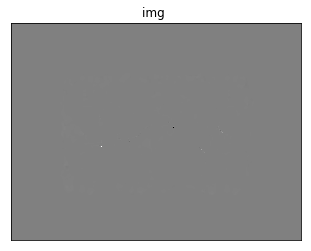

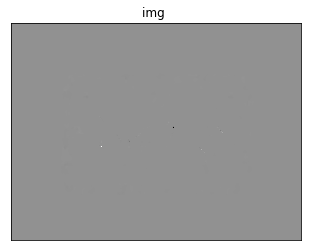

In [89]:
printLK(UV)

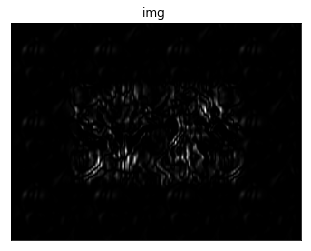

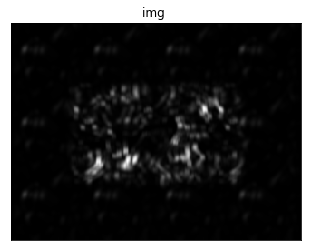

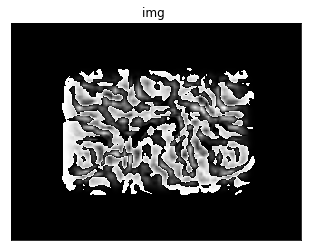

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[-0.53878984  0.02842346]
[-0.57048056  0.34160554]
[-0.7170192   0.62270583]
[-0.57236626  0.53998174]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.00114565  0.00768752]
[ 0.00300504  0.02393602]
[ 0.00413738  0.05911249]
[ 0.00635563  0.08370128]
[ 0.01207594  0.08444638]
[ 0.00957033  0.07172215]
[-0.00542023  0.04485928]
[-0.0230415   0.01472343]
[ 0.81225386  1.56019777]
[ 1.56657512  2.7318282 ]
[ 2.59237078  3.77365707]
[ 3.46167666  3.94326628]
[ 3.18989867  3.98212717]
[ 1.2895715   5.00812256]
[-2.99127983  8.24586016]
[ -4.80523714  10.24096539]
[ -5.24840802  11.23458594]
[-3.38882196  9.42990411]
[-1.28260374  5.90576738]
[ 1.03334251 -0.07886152]
[ 1.77403843 -4.61645189]
[ 1.48033021 -7.51267659]
[ 0.55948367 -9.43778532]
[ -0.260

[  1.26054605e+01  -2.26679007e-03]
[ 6.64346985 -2.14129748]
[ 4.56582954 -3.47072167]
[ 5.21839547 -4.1209391 ]
[ 5.2663599  -4.96818696]
[ 2.86711854 -5.38083474]
[-1.94762341 -0.23933371]
[-1.91135157  4.27696241]
[-1.65407385  3.58436694]
[-2.87590004 -0.61053707]
[-2.97890081 -1.07638576]
[-1.5234538   1.22238434]
[-0.34617709  2.62882016]
[ 1.11066489  3.86298737]
[ 3.08863149  4.86877115]
[-0.49279407  4.29578657]
[-1.02913891  3.97438106]
[-10.39408668   1.20417202]
[-15.0229954   -0.45006797]
[-8.0887646   0.47177258]
[ 1.53965124  1.44364898]
[ 0.32819492  1.16870351]
[-3.03703771  1.58848826]
[-6.32119328  2.72747551]
[-5.81193223  3.34482108]
[ 0.21926163  1.17418262]
[ 5.77809428 -1.45036328]
[ 8.67320179 -2.80896274]
[ 6.93729456 -0.14156434]
[ -4.39455166  10.39844604]
[-11.24609905  18.31445299]
[ -7.00830909  15.36308192]
[ -1.75404865  10.86305465]
[ -1.99880173  11.02667143]
[ -3.00061553  12.62163605]
[ -2.75357392  13.05630688]
[ -4.37587418  15.6246137 ]
[ -3.772

[-0.59109665  0.51450611]
[ 0.05576384  0.17012893]
[ 0.42593581  0.09274075]
[ 0.67746495 -0.14670956]
[ 0.65801645 -0.30973386]
[-1.03119785 -0.81395049]
[-3.79953334 -1.34964996]
[-6.39822718 -1.44027769]
[-9.98074795 -0.61028803]
[-9.88658382 -1.12479551]
[-4.56034017 -4.34102999]
[-1.02911872 -5.05417078]
[ 2.43032775 -4.23004981]
[ 7.10160323 -2.83428078]
[ 3.0394974  -5.49653916]
[ 1.48838436 -6.65362234]
[ 1.95920605 -6.55465463]
[ 1.72839507 -5.66212179]
[ 1.68885306 -4.25468397]
[ 2.11544253 -2.79505957]
[ 2.6063002 -1.8397709]
[ 2.3978745  -0.83565735]
[ 1.40539578  0.35481566]
[-0.16220197  1.47204661]
[-1.27269755  1.1555645 ]
[-2.03656018  0.417901  ]
[-2.29576015 -0.12052033]
[-1.66614643 -0.05622511]
[-0.12279617  0.27427201]
[-0.03602646  0.35101082]
[ 0.06921301  0.39114365]
[ 0.34274312  0.35408664]
[ 0.61169758  0.28208866]
[ 0.63782406  0.27292707]
[ 0.55016871  0.31080729]
[ 0.41211855  0.37278751]
[ 0.08094927  0.40333229]
[-0.37955504  0.35830375]
[-0.63672941  

[ 1.00956121  0.26601349]
[ 0.95185782  0.65105822]
[ 0.71347299  0.7046174 ]
[ 0.51097131  0.45342845]
[ 0.38243384  0.28813763]
[ 0.45311458  0.16018743]
[ 0.59030453  0.07628224]
[ 0.44568934  0.08214174]
[ 0.37140838  0.08628434]
[ 0.63743036  0.07375451]
[ 0.25172733  0.3923612 ]
[-0.50777003  0.90170424]
[-2.135582    1.99082456]
[-3.00416035  2.81427926]
[ 0.88187595  2.02453002]
[ 3.56665756  1.98292706]
[ 4.96780698  2.3327832 ]
[ 5.26844177  2.46861991]
[ 4.79629659  2.56674812]
[ 3.72455731  2.38044964]
[ 1.89867842  2.09779973]
[-1.59226168  2.00852167]
[-3.48097759  2.10854529]
[-4.97607795  2.33762861]
[-3.96033404  2.25380374]
[-3.2258668   2.18241238]
[-2.69495283  2.22850292]
[-2.05418026  2.36646995]
[-1.80748027  2.18823837]
[-1.6375356   1.46511631]
[-0.83932663 -0.1585594 ]
[-0.26918064 -1.1969657 ]
[-1.49308119 -1.1770675 ]
[-3.16702657 -0.54347864]
[-3.20840142 -1.00900637]
[-1.62974671 -1.95993775]
[-0.69076985 -2.32951987]
[ 0.40882884 -2.37630972]
[ 1.34199575

[-1.54539646  3.53743302]
[-1.22753776  2.96187183]
[-1.00835721  1.80780975]
[-0.77173146  0.78102623]
[-0.05786988 -0.0194502 ]
[-0.0301245 -0.0088904]
[-0.01094652 -0.00330244]
[-0.00279889 -0.00094351]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[-0.08952969  2.28618523]
[ -5.0483803   10.54615627]
[ -9.05788105  17.89109128]
[-10.85397005  23.0413443 ]
[ -7.59249487  20.91672256]
[ -8.04504066  14.87161875]
[-4.15578167  3.03359937]
[-2.01845592 -1.10999018]
[-0.99710463 -0.82839855]
[-0.70571801 -0.38508976]
[-0.46658363 -0.13988811]
[-0.17890094  0.09544127]
[-0.04721297  0.05705587]
[ 0.76953673 -0.08196299]
[ 1.33206816 -0.29085272]
[ 1.46456413 -0.22653653]
[ 1.64766199  0.01759967]
[ 1.99545702  0.27653514]
[ 2.02304775  0.73628925]
[ 2.09274969  1.30932013]
[ 2.02546349  1.86392471]
[ 2.05087002  1.99052553]
[ 2.68888492  1.37233692]
[ 3.46939112  0.90857905]
[ 4.68434482  0.62816578]
[ 5.49364345  0.40102766]
[ 6.21949015  0.18941235]
[ 1.2428083   0.40992985]
[-0.04477673  0.32204112]
[-0.60

[-0.63150327  0.09914247]
[-0.61699797 -0.28301147]
[-0.48738968 -0.47185346]
[-0.17346691 -0.21758449]
[-0.05212153 -0.14112104]
[ 0.44454496  0.01706644]
[ 0.72896656  0.16388529]
[ 0.76468246  0.33618576]
[ 1.07756502  0.30443794]
[ 1.86247445  0.60672959]
[ 2.56848252  1.1496453 ]
[ 2.00075927  1.16358869]
[ 1.00046349  0.48172844]
[ 1.18303697  1.05793082]
[ 1.3468596   1.47487993]
[ 1.49683892  1.91775298]
[ 1.46161225  2.22350931]
[ 1.19570504  2.30401083]
[ 0.15967858  2.39824799]
[-0.08771171  2.42325563]
[-0.989124    2.10671419]
[-0.36159028  1.92884397]
[ 0.15138508  1.98475325]
[ 0.48280926  2.26094148]
[ 0.27541342  1.9149303 ]
[-0.11897595  1.05001027]
[ 0.04770965  1.38084326]
[ 0.18854826  1.60055606]
[ 0.19989716  1.57302473]
[ 0.22374871  1.35373756]
[ 0.90574416  0.8180247 ]
[ 1.12348801  0.01939647]
[ 1.25127814 -0.16308569]
[ 1.36798215 -0.25088917]
[ 1.71479708 -0.60926665]
[ 1.73957873 -0.04610128]
[ 1.75764951  1.31168634]
[ 1.88956036  2.30642563]
[ 2.30867081

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 3.74069981 -3.19931599]
[ 6.84043574 -5.73058075]
[ 5.10352241 -4.61699919]
[ 3.52570724 -3.90266654]
[ 2.50959804 -3.90477878]
[ 1.90489231 -4.39877387]
[ 2.30120995 -4.54945415]
[ 1.0491

[ 0.3569353   0.88676053]
[ 0.52469853  0.57887957]
[ 0.62326928  0.54954433]
[ 0.85759208  0.42104838]
[ 1.17749403  0.1633229 ]
[ 1.43369603 -0.0812864 ]
[ 1.51475575 -0.13960008]
[ 1.30725498 -0.1652619 ]
[ 0.91140606 -0.00412309]
[ 0.18169828  0.2332867 ]
[-1.25408333 -0.5042444 ]
[-2.29409644 -1.08865352]
[-1.86537718 -0.54520385]
[-1.60850677 -0.34046235]
[-1.36977195 -0.18938998]
[-1.60037744 -0.17048305]
[-1.35198724  0.00656372]
[-0.53989454  0.20691071]
[ 0.23031911  0.53736013]
[ 0.41176525  0.75682221]
[ 1.03939345  1.26185684]
[ 0.91745901  1.2286113 ]
[ 0.36423359  1.01083374]
[ 0.16305637  1.12577127]
[ 0.07061648  1.18937296]
[-0.13626391  1.37937447]
[-0.52843056  1.8207802 ]
[-0.96423099  2.26127544]
[-1.07720182  2.26535968]
[-1.07720168  2.08633769]
[-1.46770342  1.97657797]
[-1.03750055  1.34996313]
[-0.23150713  0.62414134]
[-0.29761482  0.48194848]
[-0.30911939  0.44160779]
[-0.28481675  0.39885425]
[-0.22571625  0.34230645]
[-0.14470701  0.26680406]
[ 1.01769299

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 3.16397666 -2.59102364]
[ 4.49689326 -3.51816212]
[ 4.61179215 -3.51840787]
[ 4.64351003 -3.38380774]
[ 4.11842573 -3.30687039]
[ 3.49594615 -2.70292982]
[ 3.05622278 -2.75694482]
[ 2.96390832 -2.10875827]
[ 2.90406537 -0.85428784]
[ 2.73166454  3.87543132]
[ 2.15356252  6.50927213]
[ 1.86796524  5.05291777]
[ 1.35047815  3.31470832]
[ 0.49588533  2.03631192]
[-0.34133694  0.80278718]
[-0.25088874  0.34612609]
[-0.4705663  -0.54039659]
[-0.39361979 -0.63620657]
[-0.11758207 -0.61728386]
[ 0.17122659 -0.59521477]
[ 0.3500827  -0.56398114]
[ 0.68017907 -0.43675326]
[ 1.23996777 -0.35088022]
[ 1.45581372 -0.34730039]
[ 0.62652108 -0.47378809]
[-0.41584419 -0.5230189 ]
[-0.88020835 -0.5146769 ]
[-0.56373973 -0.44179226]
[-0.41879188 -0.404388

[-0.6008926  -0.25922865]
[-0.66469   -0.4056828]
[-0.86960991 -0.39181092]
[-1.42534191 -0.41057169]
[-1.988915   -0.37457007]
[-1.40141247 -0.21582867]
[ 1.66601649 -0.1706794 ]
[ 1.53739326 -0.28518175]
[ 1.83546153 -0.42800665]
[ 2.09808572 -0.47638845]
[ 1.95001748 -0.419409  ]
[ 1.33832312 -0.16795028]
[ 1.32133119 -0.03710251]
[ 1.55342611  0.05224223]
[ 1.36002999  0.1500994 ]
[ 2.10562149  0.00602051]
[ 1.23967673  0.13430143]
[ 0.43454917  0.27349207]
[ 0.38722086  0.22904957]
[ 0.41527991  0.15162552]
[ 0.51610473  0.02669779]
[ 0.52013454 -0.0063758 ]
[ 0.08767273  0.27232653]
[-0.04344868  0.37142359]
[-0.01116258  0.40727686]
[ 0.27841728  0.48256298]
[ 0.64988032  0.89343869]
[ 0.57048904  1.30193373]
[ 0.63493706  1.30099289]
[ 0.53804247  0.9009997 ]
[ 0.30015464  0.59870546]
[ 0.01128713  0.41244503]
[-0.09712949  0.34538882]
[ 0.19710782  0.2292802 ]
[ 0.39236751  0.18109549]
[ 0.46858164  0.18345731]
[ 0.30866448  0.33092332]
[ 0.61884824  0.38369788]
[ 0.63611157  

[-0.21380785 -0.03598164]
[-0.12069538 -0.10088656]
[-0.06247464 -0.09844667]
[-0.033931   -0.07572224]
[-0.01654871 -0.0496257 ]
[-0.00162043 -0.0179481 ]
[ 0.00221727 -0.0021825 ]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.00240213  0.00068608]
[ 7.18281677 -1.88275657]
[ 8.52630749 -2.70320096]
[ 8.53109668 -2.98943899]
[ 8.00400291 -2.9538585 ]
[ 6.48702157 -0.6794256 ]
[ 5.11437667  2.17303052]
[ 4.7434707   2.80726468]
[ 3.94295758  3.27351883]
[ 3.21428519  1.78156676]
[ 2.7482929  -0.88177038]
[ 2.32505008 -2.08169131]
[ 2.09197795 -2.0920452 ]
[ 1.69263725 -2.12763615]
[ 0.88823045 -1.6227912 ]
[-0.02776654 -0.8361135 ]
[-0.55381752 -0.32716879]
[-0.70264565 -0.20173776]
[-0.61497773

[ 1.34867361 -0.41725812]
[ 2.26532149 -0.40316216]
[ 3.47672536 -0.2895384 ]
[ 2.20717407 -0.13130321]
[ 0.90350793 -0.09110286]
[-0.57166851  0.12911241]
[-0.52450977  0.08489801]
[-0.25713328  0.07051895]
[-0.1970066   0.02600813]
[-0.23601804 -0.0638743 ]
[-0.28716187 -0.14919473]
[-0.34490762 -0.28105334]
[-0.26278655 -0.39860448]
[-0.19672341 -0.48082839]
[-0.11410302 -0.51419568]
[ 0.27632204 -0.19629475]
[ 0.72289966  0.28437862]
[ 0.31312758 -0.40208154]
[-0.0561071  -1.04951753]
[-0.48715342 -1.90796434]
[-1.09984924 -2.71641492]
[-1.50005045 -1.12660557]
[-1.59733789 -0.26239319]
[-1.5083535  -0.11925243]
[-1.20418799 -0.23054912]
[ 0.62328645 -0.25581956]
[ 1.73232003 -0.17256079]
[ 2.10922796 -0.26476855]
[ 2.45108514 -0.35170616]
[ 3.10029013 -0.40421213]
[ 3.72196502 -0.42188094]
[ 3.99517892 -0.24073611]
[ 3.20831329  0.27836025]
[ 2.41089382  0.55790799]
[ 1.13367949  0.36233069]
[-0.09868467  0.10157441]
[-0.38524717 -0.00053949]
[-0.33888996  0.01647898]
[-0.29680274

[-0.00897023  0.00049612]
[-0.00335651 -0.00161602]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.

[ 0.48383508  0.34637948]
[ 0.26606351  0.29077332]
[-0.03020046  0.24215923]
[-0.30656943  0.22481329]
[-0.10425243  0.27859276]
[-0.01102768  0.30361279]
[-0.04500953  0.32917269]
[-0.09569423  0.36462958]
[-0.02334929  0.37894249]
[-1.11560646  1.6736242 ]
[-0.45413136  1.13756641]
[-0.21545607  1.11855944]
[ 0.08709139  1.37549091]
[ 1.18439178  2.06793024]
[-1.34234608 -0.3967039 ]
[-0.79444229  0.11152317]
[-0.64543882  0.176305  ]
[-0.35086917  0.30721259]
[-0.28316612  0.36127076]
[-0.17289479  0.45134363]
[-0.13304089  0.47578754]
[-0.14195743  0.47610249]
[-0.18100365  0.48541033]
[-0.27777664  0.5097416 ]
[-0.32455179  0.48390787]
[-0.15854444  0.32727385]
[ 0.06472033  0.14251648]
[ 0.12076695  0.07990681]
[ 0.26256735 -0.01069465]
[ 0.34369457 -0.05136104]
[ 0.32666419 -0.04184416]
[ 0.34331235 -0.0516353 ]
[ 0.35405312 -0.07185438]
[ 0.25008088 -0.03463356]
[ 0.1210507   0.01040221]
[ 0.01506957  0.02177236]
[-0.1500493   0.00664138]
[ 0.0289799   0.07750696]
[ 0.38184417

[-0.5848007  -0.25476245]
[-0.46135679 -0.10730098]
[ 0.08273903 -0.14387107]
[ 0.14837005 -0.01039918]
[ 0.07772401  0.30193093]
[ 0.0165791   0.30763047]
[-0.00159587  0.49525152]
[ 11.39431893   1.59816421]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[-0.24601017 -0.40968662]
[-0.24529304 -0.27517057]
[-0.25635455 -0.15552076]
[-0.25219193 -0.01281025]
[-0.23052704  0.07377574]
[-0.26089257  0.10070788]
[-0.36287192  0.10429545]
[-0.86462738  0.02246729]
[-2.4269639  -0.22942568]
[-2.93620889 -0.26353834]
[-2.94491536 -0.18193779]
[-0.39133362  0.24764501]
[ 1.33175446  0.4693194 ]
[ 1.4446662   0.46765132]
[ 1.09393159  0.43931974]
[ 1.0283331   0.44612125]
[ 0.85127505  0.45143523]
[ 0.5959194   0.44920204]
[ 0.20549618  0.35492566]
[-0.72364213 -0.38785162]
[-1.22781661 -0.82371543]
[-1.10804466 -0.57229192]
[-0.87769421 -0.22981318]
[-0.11617308  0.53603225]
[ 0.5624753   0.86553348]
[ 1.51130167  1.18851545]
[ 0.14055427  1.35995917]
[-1.56319456  1.77

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 10.09347811  -1.87934987]
[ 18.9108993   -2.56112144]
[ 12.77309287  -3.42476667]
[ 7.20097427 -5.33566035]
[ 3.04957708 -9.0608018 ]
[ 5.99731319 -7.13931819]
[ 8.00994535 -5.14663032]
[ 10.85348709  -1.19071264]
[ 12.38317967   2.31367565]
[ 8.97285271  0.46470423]
[ 5.08925407 -1.80026747]
[ 3.32770839 -1.61452047]
[ 3.16800332 -0.66074737]
[ 3.21202443 -0.07061651]
[ 3.38443952  0.52698021]
[ 3.87531826  1.63251872]
[ 4.3638337   2.56565452]
[ 5.02190194  3.68635982]
[ 6.16419757  6.75840274]
[  8.62479212  18.16559203]
[ 10.91677048  30.67429695]
[ 12.46303446  25.29864498]
[ 13.78312419  11.93027024]
[ 11.57707144   6.33845792]
[ 3.1883667   1.83107631]
[-8.18250651 -1.65782333]
[-7.13375766 -1.18318822

[ -6.97598798 -13.9704544 ]
[ 18.74757377  18.5143063 ]
[ 30.09250728  33.6783867 ]
[-0.66014644  3.30547409]
[ 0.1398591   3.58712111]
[-0.04795621  3.24862501]
[-1.37463903  0.55436053]
[-1.9370659  -0.78000629]
[-1.62593446 -0.91901646]
[-1.58038729 -1.28673727]
[-0.84093588 -1.33377082]
[-0.25996158 -1.15359288]
[-0.15154789 -1.41853092]
[ 0.14815119 -1.54313161]
[ 0.33871693 -1.62815052]
[ 0.04223588 -1.70829185]
[ 4.58037492 -1.2061688 ]
[ 3.6683363  -1.44407718]
[ 3.11669687 -1.51380893]
[ 3.5937786 -1.4992281]
[-1.14960375 -1.16153006]
[-8.08316118 -0.74029124]
[-10.98159119  -0.64201094]
[-15.46982384  -0.86043317]
[-11.53979328  -1.21507748]
[-9.12857255 -1.27323923]
[-7.82019996 -1.17833873]
[-7.18201846 -1.29789537]
[-6.74298646 -1.48463229]
[-5.48787619 -1.20013837]
[-3.99761206 -1.48420974]
[-3.74599397 -2.19353708]
[-3.80780377 -2.93545591]
[-3.31175494 -2.56716738]
[-2.41366994 -1.69499932]
[-1.73045227 -0.94288297]
[-1.04678482 -0.33666221]
[-0.30153876  0.29355048]
[ 

[-0.07601711 -0.01383664]
[-0.05465562 -0.01366918]
[-0.02612221 -0.00898881]
[-0.00548375 -0.00282169]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  

[ 3.40617013  0.16567186]
[ 0.64947769  0.46413659]
[ 0.5878596   0.51678855]
[ 1.8759472   0.65101129]
[-0.34286744  0.35095005]
[-0.6434263   0.29894818]
[-0.57769725  0.25378782]
[-0.06515157  0.17467071]
[ 0.13143242  0.08495422]
[ 0.02864876  0.0855457 ]
[-0.01864008  0.0856056 ]
[-0.05251512  0.08987969]
[-0.07869107  0.09811858]
[-0.1274061  0.1180764]
[-0.16488513  0.13572238]
[-0.06475106  0.06361515]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[-0.0008929   0.01036352]
[-0.08062112  0.01064205]
[-0.14964351 -0.18770703]
[-0.13715803 -0.60444621]
[-0.10962038 -0.82440247]
[-0.09091864 -0.95007568]
[-0.14489095 -0.89313842]
[ 0.22066215 -0.89731385]
[ 0.05849695 -1.23408718]
[-0.32518341 -1.64240003]
[-0.12913421 -1.78820158]
[ 1.0904619  -1.75272415]
[ 0.11029657 -2.13257921]
[ 0.30250055 -2.15560051]
[ 0.64759398 -1.91158883]
[ 0.7616477  -1.77449527]
[ 0.8144441  -1.66098237]
[-0.05211953 -3.66521316]
[-1.49449876 -8.45245489]
[-0.5947651  -4.22846272]
[-1.28518286 -1.

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[-1.1624525  -0.22581593]
[-1.57411322 -0.9385183 ]
[-1.44917074 -3.03347413]
[-0.3998069  -8.30988204]
[  1.08222259 -15.673417  

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[-2.42013608  3.72178725]
[-4.18289583  7.9180714 ]
[ -4.90734359  10.70906434]
[-4.1360436   9.97788629]
[-1.2419553   4.06863394]
[ 2.68670051  5.54260814]
[  3.85918142  10.10327856]
[ 3.65742544  8.08625738]
[ 3.38416676  4.89252523]
[ 3.16265004  1.19211887]
[ 2.89201806 -1.60703639]
[ 2.64219876 -2.35563209]
[ 2.44189293 -2.50688298]
[ 2.31078182 -2.15895676]
[ 2.21261319 -1.78840553]
[ 2.18498382 -1.66066915]
[ 1.81721937 -1.8521603 ]
[ 0.66132427 -

[-2.40280355 -0.16418429]
[-3.61820279  1.48748676]
[-3.79898499  2.03262048]
[-1.54368076  0.72377753]
[ 0.97853078 -1.33666036]
[ 1.39785648 -2.04999945]
[ 1.38499499 -2.5735198 ]
[ 1.4654248  -2.95613308]
[ 0.78787968 -2.76467145]
[ 0.59368237 -2.67842109]
[ 0.74966518 -2.3558426 ]
[ 1.08873072 -1.40265961]
[ 1.48486316  0.69603025]
[ 1.47081052  1.62063963]
[ 1.1851744   1.24851604]
[-1.20345829  1.66686121]
[-1.42650218  0.95275248]
[-1.04989226  0.56897478]
[-1.05184567  0.26787613]
[-0.93238695 -0.22037806]
[-0.64984435 -0.23292909]
[-0.17146068 -0.38841116]
[-0.11733005 -0.32888339]
[ 0.84623402 -0.58162272]
[ 0.94659371 -0.48167795]
[ 0.94504713 -0.29481863]
[ 1.2007973   0.19762979]
[ 1.25687885  0.81542297]
[ 0.37672308  1.65391363]
[-0.09532399  1.18663522]
[-0.20120226  0.77587056]
[-0.3070544   0.42502824]
[-0.39826679  0.10663286]
[-0.4080987   0.03755281]
[-0.40200452  0.53418291]
[-0.54088895  0.89303687]
[-0.50251814  0.50598769]
[ 0.55094816  0.08669368]
[ 1.06768497

[-0.5241435   0.80299178]
[-0.1897584   1.11377783]
[-0.23994233  1.03486734]
[-0.22294513  0.913912  ]
[-0.18240936  0.24787733]
[ 0.00206266  0.62572791]
[ 0.12907247  0.67390361]
[ 0.11936791 -0.70937766]
[-0.21530956 -2.041381  ]
[-0.15572007 -1.51370195]
[-0.24348443 -0.67580757]
[-0.39900641 -0.22015191]
[-0.32803089 -0.60276191]
[-0.14359637 -0.83143698]
[-0.16264267 -0.81759584]
[-0.12641011 -0.93056122]
[ 0.42901672 -1.12128063]
[ 0.00466622 -1.64643609]
[-0.71412021 -2.41109705]
[-0.17498077 -2.21048002]
[ 0.12743518 -1.83620256]
[-1.09963944 -1.39912882]
[-1.00252551 -1.34439428]
[ 0.05766308 -1.15809867]
[ 0.46637663 -0.93677981]
[ 0.49072491 -0.97038436]
[-0.12717587 -1.67351411]
[-0.15600731 -1.9771443 ]
[-0.25489892 -2.1033219 ]
[-0.43837721 -1.73804382]
[-0.49534123 -1.2520924 ]
[-0.76821928 -0.04596494]
[-0.77071877  0.20310959]
[-0.56540939 -0.3204023 ]
[ 0.4505304  -1.74285772]
[ 1.14571294 -1.63499409]
[ 1.76473573 -0.30534339]
[ 1.94032031  0.27404405]
[ 2.21401602

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[-3.00343348  7.76639584]
[ -4.02474457  11.23512132]
[-1.79190946  9.63033852]
[ 0.8645623   8.28711786]
[ 6.22218234  6.7183625 ]
[ 8.00479917  6.24727622]
[ 4.17903299  6.62364935]
[ 1.83223466  7.05198685]
[ 0.93186267  7.48353783]
[-2.45326114  9.23131871]
[-2.59983084  8.69874206]
[-1.96881881  5.85615331]
[-1.38649831  0.53987731]
[-1.50402283 -1.36039924]
[-1.09525547 -0.67468894]
[-0.57513582 -0.06761088]
[ 0.617007    0.60142071]
[ 1.65323362  1.00373942]
[ 1.77647041  1.49894814]
[ 0.69905909  3.06131275]
[ 0.30399302  3.50506408]
[-0.58242457  2.53354526]
[-1.75529355  0.60044742]
[-1.84653659 -0.6320

[ 0.07802791 -1.45565364]
[-0.64533552 -2.09778649]
[-0.96412494 -2.7834151 ]
[ 0.08280001 -2.05071586]
[ 1.51514052 -1.32710916]
[ 1.86513063 -0.65167046]
[ 1.67000938  0.3840076 ]
[ 1.80965088  0.69789239]
[ 1.75519172  0.34014148]
[ 1.52408985 -0.19720738]
[ 0.60144042 -1.35464933]
[-0.17042171 -1.84197085]
[-0.37151846 -1.25163507]
[-0.59119891 -0.27131214]
[-0.70303044  0.42233736]
[-0.48972263  0.77412939]
[-0.05738373  0.79518538]
[ 0.12358293  0.72310557]
[ 0.31045393  0.61834692]
[ 0.45928526  0.5697985 ]
[ 0.40999947  0.46873654]
[ 0.25818467  0.4680783 ]
[ 0.30888635  0.35544368]
[ 0.27685211  0.17492721]
[ 0.24226028 -0.12459967]
[-0.16593353 -0.33969919]
[-0.68344288 -1.54462043]
[-0.5524216  -1.01255858]
[-0.37700086 -0.08521508]
[-0.42396169 -0.040301  ]
[-0.28626709  0.32247421]
[ 0.19597752  2.44616343]
[ 0.12509506  2.56930033]
[ 0.26725241  2.25724669]
[ 0.50412169  0.80740007]
[ 0.59095779  0.76831438]
[ 0.68900988  0.57150407]
[ 0.68589664  0.45026183]
[ 0.72415633

[-0.01459628  0.85387489]
[-0.13767926  0.76606159]
[-0.51377812  0.32747082]
[-0.49015512  0.29286203]
[-0.16549943  0.57100586]
[ 0.03555614  0.70612808]
[ 0.3910854   0.88068933]
[ 0.38475431  0.70830295]
[ 0.29871896  0.64593159]
[ 0.49739793  0.40857963]
[ 0.91522824 -1.26331582]
[ 1.08584808 -2.95624816]
[ 1.02541757 -2.89213663]
[ 1.09925898 -1.53847724]
[ 1.20476354 -1.00040946]
[ 1.0030517  -2.00753032]
[ 0.43045429 -4.00754972]
[-0.06656893 -5.49393657]
[-0.72900183 -7.4888741 ]
[ -2.63947924 -10.93309814]
[-1.65344309 -8.83057416]
[-2.37510747  1.01034976]
[-2.89180276  4.3930211 ]
[-2.34200611  2.75293092]
[-1.44189727  0.92518031]
[-0.52327059 -0.05081191]
[-0.2113577  -0.35251041]
[-0.42007926 -0.17217116]
[-0.48691857 -0.17203947]
[ 0.01927887 -0.50524645]
[ 0.0784333  -0.54632517]
[ 0.12079017 -0.59702409]
[ 0.17303929 -0.65668874]
[-0.13372149 -0.08946792]
[-0.06488445 -0.23713951]
[ 0.20824116 -0.57600355]
[ 0.44572251 -0.70391894]
[ 0.72955707 -0.73106682]
[ 0.526436

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 2.08975053 -4.19187207]
[ 3.11650228 -5.58749531]
[ 3.71527079 -6.1040302 ]
[ 3.35012233 -6.02151164]
[ 2.99908042 -6.15709945]
[ 2.94946849 -6.05727971]
[ 2.10442502 -5.25637832]
[ 2.49961222 -5.09670237]
[ 4.43139055 -5.38689043]
[ 3.84151344 -4.57395609]
[ 0.35496947 -1.36801081]
[-0.19436214 -0.35464922]
[-0.26902447  0.11282001]
[-0.28199686  0.09285458]
[-0.30393327  0.04366677]
[-0.35882434 -0.10072356]
[-0.45101269 -0.35018343]
[-0.58431842 -0.57507012]
[-0.64488534 -0.60168527]
[-0.71532463 -0.49256366]
[-0.93257818 -0.46751211]
[-1.51988653 -0.44486801]
[-3.62483662 -0.10441926]
[-7.02311596  0.56901618]
[-4.24870265  0.0324252 ]
[ 2.41854287 -1.34853912]
[ 2.54678187 -1.36047603]
[ 2.58839742 -1.39339568]
[ 2.23225406 -1.34251185]
[ 1.58997057 -1.04602634]
[ 1.24195205 -0.77248113]
[ 0.88486021 -0.46421901]
[ 0.54753672 -0.22493841]
[-0.27440806  0.35748561]
[-0.73859829  0.6295074 ]
[-0.9025189   0.69623823]
[-1.05732307  0.70738021]
[-1.0382

[ 2.53153495  0.04798282]
[ 2.94667079 -1.36386716]
[ 2.83295539 -2.23551171]
[ 2.40170648 -2.91186711]
[ 1.56393554 -5.02008011]
[ 0.53179493 -6.80308328]
[-1.13478774 -9.42355731]
[-2.10147347 -9.73517939]
[-2.06753831 -7.26230792]
[-1.5022233  -4.37253586]
[-1.06572483 -2.67249762]
[-0.79174328 -1.9652782 ]
[-0.51048998 -1.31514608]
[-0.34528694 -0.05497327]
[-0.40919475  0.01191548]
[-0.40283221  0.21054188]
[-0.41731452  0.30818143]
[-0.45860381  0.34304281]
[-0.623655    0.37856712]
[-0.23310896  0.49166938]
[-0.26964617  0.48159861]
[-0.45385973  0.26425765]
[-0.59068172  0.12632858]
[-0.62927581  0.13727091]
[-0.60354556  0.27956944]
[-0.64862023  0.40498784]
[-0.73187825  0.47627417]
[-0.48121774  0.43953008]
[ 0.52556123  0.22157185]
[ 1.11444353  0.06812536]
[ 0.31965232  0.24153461]
[ 0.27699318  0.23751298]
[ 0.27850655  0.2056838 ]
[ 0.52537045  0.04783524]
[ 0.69972343 -0.08905535]
[ 0.43693882  0.00805637]
[ 0.86484378 -0.38930801]
[ 0.63732493 -0.30579037]
[-0.09856483

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 3.12678413 -2.55535975]
[ 4.71371853 -3.74110023]
[ 4.47829745 -3.5133704 ]
[ 4.4193807 -3.385692 ]
[ 4.12516394 -3.50889493]
[ 4.09232167 -3.27238992]
[ 4.2746767  -2.67758104]
[ 4.53371105 -2.10412278]
[ 4.7175755  -1.27669347]
[ 4.91141182 -0.15779531]
[ 4.90440676  1.72451548]
[ 4.06825978  4.94848585]
[ 4.56535253  3.2701468 ]
[ 4.

[ 1.11659645 -1.31858518]
[ 1.27096424 -1.37904679]
[ 1.17056994 -1.77181887]
[ 0.72607455 -2.50226487]
[-0.09407543 -3.53733947]
[-0.66228364 -3.24143978]
[-2.14083915 -1.16723423]
[-2.40184256  0.46749978]
[-1.93635685  0.71089571]
[-1.48604876  0.45225759]
[-1.05288751  0.4023571 ]
[-0.5932065   0.50794831]
[-0.79275592 -0.16710852]
[-1.12535229 -0.70421923]
[-1.11769486 -0.3149929 ]
[-1.1705902   0.26441797]
[-1.48705294  0.71518451]
[-1.41885186  0.86763536]
[-0.41128421  0.5766663 ]
[ 0.91970889  0.03999135]
[ 0.7804798   0.12080519]
[ 0.83662174  0.09665003]
[ 0.4706943   0.25418951]
[ 0.24360981  0.33273679]
[-0.01766938  0.37323466]
[-0.20142721  0.34329497]
[-0.3495731   0.29945546]
[-0.22901533  0.52031998]
[-0.01983518  0.80825456]
[ 0.00370813  0.92388199]
[-0.13925338  0.95056242]
[ 0.18664737  0.95567501]
[ 0.33455962  0.86074029]
[ 0.63086408  0.09397456]
[ 0.87873227 -0.86617043]
[ 1.27584132 -2.17559322]
[ 1.03265275 -2.83525368]
[ 0.77707381 -3.02976814]
[ 0.12786734

[-0.27293019 -0.13428111]
[-0.23530094  0.1262443 ]
[-0.18568241  0.23188649]
[-0.2538741  0.20721  ]
[-0.07285691  0.31826272]
[ 0.04012171  0.34910741]
[ 0.15266848  0.34851026]
[ 0.48676018  0.37028047]
[-0.00467625  0.5884635 ]
[ 0.09796484  0.57838574]
[ 0.23518753  0.58844335]
[-0.13339692  0.55553347]
[-0.03772254  0.43933389]
[ 0.09464342  0.27867451]
[ 0.88934077 -0.31157897]
[ 1.43692774 -1.38553683]
[ 1.68935035 -2.35338746]
[ 1.71623927 -3.1246854 ]
[ 1.6940777  -3.11476442]
[ 1.34845029 -3.36302238]
[ 1.13998828 -3.26127841]
[ 0.52246362 -3.05498892]
[-1.00033587 -2.67758893]
[-1.48511891 -2.38787505]
[-0.41476167 -2.45058347]
[-0.32960403 -2.41487292]
[-0.49565624 -2.33747122]
[-0.2284216  -2.38969925]
[ 0.09322692 -2.59523427]
[ 0.78304519 -3.07024354]
[ 0.69903814 -3.07287183]
[ 0.42815997 -2.95752491]
[-1.29163578 -2.70917478]
[-2.55676253 -2.70208029]
[-2.67346048 -2.56945747]
[-2.98216294 -2.48137129]
[-3.18652557 -2.41554701]
[-3.20150369 -2.66427883]
[-3.44425319 -

[ 0.  0.]
[ 0.  0.]
[ 7.02325641 -3.68563662]
[ 15.05080593  -9.39006632]
[ 23.82288021 -17.62344168]
[ 23.90091896 -17.90584237]
[ 13.88008024  -5.16712412]
[ 9.84651352  1.01299134]
[ 9.34162937  2.18420125]
[ 11.5490262   -0.66866911]
[ 13.16327185  -2.47761128]
[ 6.03390444  5.03735545]
[ 2.10193458  6.90678519]
[ 1.15076208  5.06766766]
[ 0.05298156  3.39211367]
[-1.01727736  1.74744033]
[-0.89307799  0.19427608]
[ 0.11328594  0.58460375]
[ 0.45950338  1.07779662]
[ 1.00172367  1.58507836]
[ 2.50067176  1.74066164]
[ 2.09841288  2.23596957]
[ 0.17418459  2.33609067]
[-0.43035516  2.66841224]
[-0.67947561  2.0971591 ]
[ 0.56010362  2.73040111]
[ 1.3021931   3.24912958]
[ 1.94495692  2.16793934]
[ 1.68662153 -0.58684662]
[ 1.50086095 -1.68835376]
[ 0.78525119 -3.02290824]
[ 0.14120205 -3.94730954]
[-0.42078063 -4.16395523]
[-1.21357004 -3.94026348]
[-0.95327677 -3.68221212]
[-0.66737792 -3.54983105]
[-0.56655611 -3.25519899]
[ 0.14608008 -3.06585922]
[ 0.93309484 -2.97995419]
[ 1.36

[-0.76622868 -2.92642933]
[-1.79676214 -3.85934469]
[-2.33107781 -4.16866082]
[ 0.08146083 -4.4782443 ]
[ 1.5949831  -4.67704735]
[ 0.30700272 -1.69589995]
[-2.69238909  1.40309764]
[-3.23221018  1.91649415]
[-1.64419742  0.85652993]
[-0.00954266  0.00427011]
[-0.0061169   0.00213663]
[-0.00344753  0.00088561]
[-0.0018107   0.00027255]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[-0.00601383  0.00375991]
[-0.00741429  0.0073178 ]
[-0.01004489  0.01160821]
[-0.00977213  0.00394857]
[-0.00664497 -0.01045864]
[-0.00149576 -0.02420463]
[-0.00235613 -0.02190965]
[-0.00390003 -0.01892914]
[-0.00479903 -0.01808468]
[-0.00390297 -0.01785355]
[-0.00291248 -0.01486149]
[-0.00204703 -0.01235079]
[-0.00131608 -0.01005115]
[ 0.00320674  0.00240326]
[ 0.00446511  0.00534649]
[ 0.00726662  0.00483912]
[ 0.

[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[-0.00454441 -0.00118169]
[-0.00955756 -0.00317517]
[-0.01205113 -0.00501025]
[-0.00399567 -0.00537416]
[ 0.00054858 -0.00899262]
[ 0.00149548 -0.01175344]
[ 0.00144972 -0.01079308]
[ 0.00029329 -0.00602886]
[-0.0002238  -0.00255923]
[-0.00025062 -0.00090011]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]


In [ ]:
s0 = cv2.imread('./images/TestSeq/Shift0.png',0) 
s5 = cv2.imread('./images/TestSeq/ShiftR5U5.png',0) 
UV2=LK(s0,s5,5)
printLK(UV2)